In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\joska\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig



def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [4]:

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


In [5]:

X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [6]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# # Original losses:
# # -------------------
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

In [7]:
# Alternative losses:
# # -------------------
# D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
# D_loss = D_loss_real + D_loss_fake
# G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

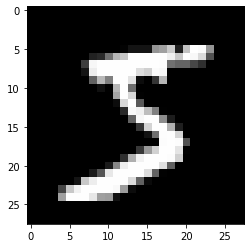

In [8]:
from datasets import MNISTDataset

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

                    
for it in range(5000):
    X_mb,_ = data.next_batch()
    if X_mb.shape == (96,784):
        print(X_mb.shape)   

In [18]:
def train():
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

    mb_size = 128
    Z_dim = 100
    n_iterations = 100000
    path = "out_org_100k/"

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    if not os.path.exists(path):
        os.makedirs(path)

    i = 0

    for it in range(n_iterations+1):
        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

            fig = plot(samples)
            plt.savefig('out_org_100k/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

        X_mb, _ = data.next_batch()


        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

        if math.isnan(D_loss_curr):
            print("oh no loss became nan at iteration",it) 
            return False

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()
    return True

In [19]:
attemps = 0
while not train():
    attemps+=1

print (attemps)

Iter: 0
D loss: 1.442
G_loss: 2.482

Iter: 1000
D loss: 0.005127
G_loss: 7.26

Iter: 2000
D loss: 0.06981
G_loss: 5.312

Iter: 3000
D loss: 0.04599
G_loss: 5.781

Iter: 4000
D loss: 0.1338
G_loss: 5.184

Iter: 5000
D loss: 0.2665
G_loss: 4.092

Iter: 6000
D loss: 0.339
G_loss: 3.934

Iter: 7000
D loss: 0.548
G_loss: 4.381

Iter: 8000
D loss: 0.568
G_loss: 3.316

Iter: 9000
D loss: 0.7596
G_loss: 2.849

Iter: 10000
D loss: 0.9443
G_loss: 1.866

Iter: 11000
D loss: 0.6117
G_loss: 2.414

Iter: 12000
D loss: 0.8868
G_loss: 1.994

Iter: 13000
D loss: 0.7106
G_loss: 2.936

Iter: 14000
D loss: 0.6912
G_loss: 2.546

Iter: 15000
D loss: 0.7281
G_loss: 2.38

Iter: 16000
D loss: 0.6598
G_loss: 2.147

Iter: 17000
D loss: 0.8806
G_loss: 2.188

Iter: 18000
D loss: 0.6018
G_loss: 2.188

Iter: 19000
D loss: 0.8143
G_loss: 1.832

Iter: 20000
D loss: 0.7984
G_loss: 1.973

Iter: 21000
D loss: 0.9113
G_loss: 2.134

Iter: 22000
D loss: 0.6434
G_loss: 1.963

Iter: 23000
D loss: 0.8628
G_loss: 2.241

Iter: 2